# WNC Content Preservation Metric - Evaluation

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

**Goals:**

The purpose of this evaluation process is to understand the impact of the two hyperparameters -- `threshold` and `mask_type` -- on our custom content preservation metric.

To do so, we'll perform a grid search across different values of each producing a series of experiments. In each experiment, we'll calculate content preservation scores for each ground truth pair in the evalution holdout set -- producing an aggregate content preservation score.

Ultimately, we want to see if the use of style masking (under and parameter settings) is able to produce higher cosine similariy scores than we can get from just the plain input. vs ground truth (without masking).

In [2]:
from src.evaluation import ContentPreservationEvaluation

In [3]:
SBERT_MODEL_PATH = "sentence-transformers/all-MiniLM-L6-v2"
CLS_MODEL_PATH = (
    "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466"
)
DATASETS_PATH = "/home/cdsw/data/processed/WNC_seq2seq_full"

cpe = ContentPreservationEvaluation(
    sbert_model_identifier=SBERT_MODEL_PATH,
    cls_model_identifier=CLS_MODEL_PATH,
    dataset_identifier=DATASETS_PATH,
    threshold=0.3,
    mask_type="none",
)

In [42]:
cpe.evaluate()

  0%|          | 0/269 [00:08<?, ?it/s]

Saved `self.metric_df` to ./cpe_metrics/pad-0.3-metric_df.pkl


## Inspect Experimental Results

In [13]:
import os
import pandas as pd

In [16]:
DF_PATH = "~/data/output/cpe_metrics/none-0-metric_df.pkl"
none_df = pd.read_pickle(DF_PATH)

### Check CPS Score Distribution by Experiment

In [17]:
import os
import pandas as pd


def plot_experiment_distributions(cpe_metrics_path):
    """
    Gather, format, and plot CPS score distributions provided a path
    to directory where CPE experiment results are stored.

    Args:
        cpe_metrics_path (str) - path to where CPE experimental results are stored

    """

    experiments = [
        exp for exp in os.listdir(cpe_metrics_path) if not exp.startswith(".")
    ]

    data = {}
    for exp in experiments:
        df = pd.read_pickle(os.path.join(cpe_metrics_path, exp))

        exp_name = f'{exp.split("-")[0]}-{exp.split("-")[1]}'
        data[exp_name] = df.cps_score.tolist()

    pd.DataFrame.from_dict(data).plot.box(
        title="Distribution of CPS Score by Experiment", figsize=(20, 10)
    )

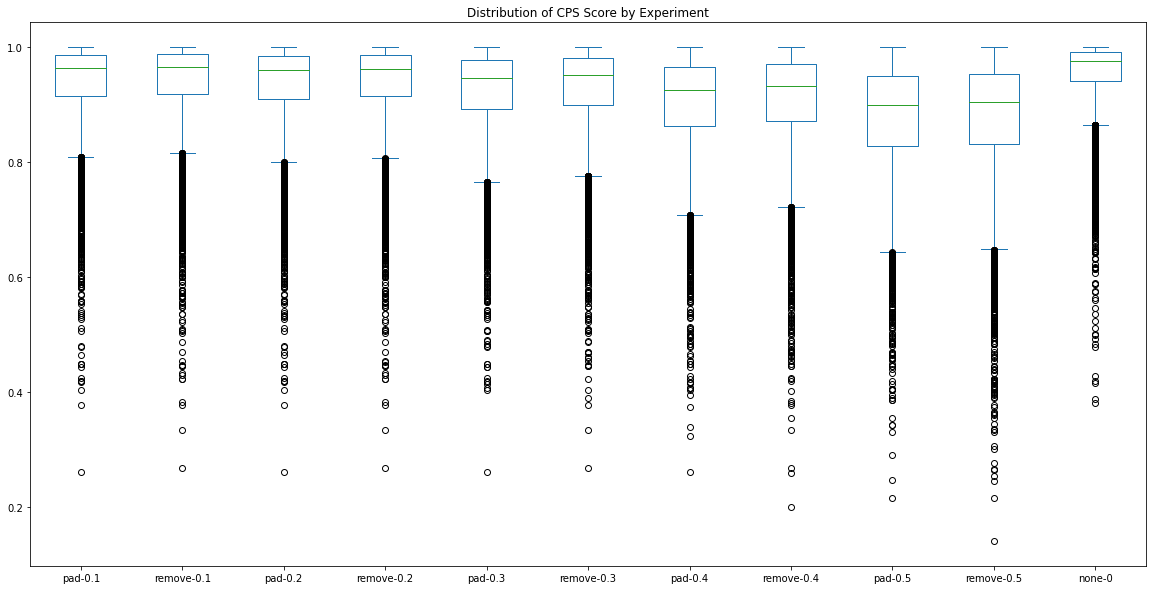

In [18]:
CPE_METRICS_DIR = os.path.join(os.path.expanduser("~"), "data/output/cpe_metrics/")
plot_experiment_distributions(CPE_METRICS_DIR)

### Check CPS Median Score by Experimental Settings

In [19]:
import os


def format_cpe_summary_stats(cpe_metrics_path):
    """
    Gather and format CPS score results from CPE experiments.

    Args:
        cpe_metrics_path (str) - path to where CPE experimental results are stored

    """

    experiments = [
        exp for exp in os.listdir(cpe_metrics_path) if not exp.startswith(".")
    ]

    data_records = []
    for exp in experiments:
        df = pd.read_pickle(os.path.join(cpe_metrics_path, exp))
        data = df.cps_score.describe().to_dict()
        data["mask_type"] = exp.split("-")[0]
        data["threshold"] = exp.split("-")[1]
        data_records.append(data)

    return pd.DataFrame(data_records)

In [20]:
CPE_METRICS_DIR = os.path.join(os.path.expanduser("~"), "data/output/cpe_metrics/")
results_df = format_cpe_summary_stats(CPE_METRICS_DIR)

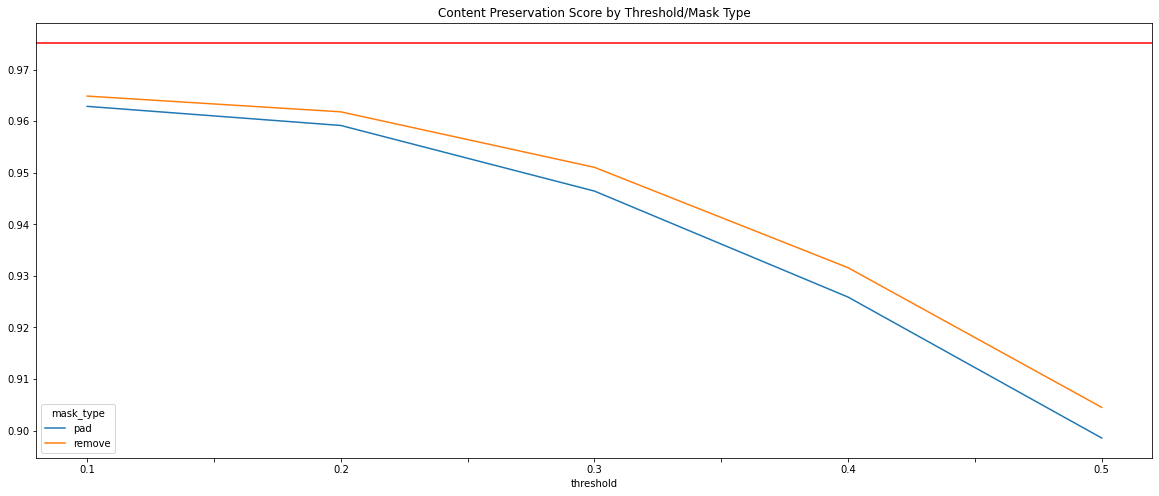

In [21]:
baseline = results_df.loc[:, ["mask_type", "threshold", "50%"]].iloc[-1]
(
    results_df[["mask_type", "threshold", "50%"]]
    .iloc[:-1]
    .pivot(index="threshold", columns="mask_type", values="50%")
    .plot.line(
        title="Content Preservation Score by Threshold/Mask Type", figsize=(20, 8)
    )
    .axhline(y=baseline["50%"], color="r")
)

**Observations:**
- Removal produces consistently higher similarity scores than padding
- Style masking in general produces lower similarity scores than the baseline where no tokens are masked
- The more tokens we mask, the lower our CPS scores.
- Low CPS score outliers from the NO STYLE MASKING experiment highlight records that should probbably be removed from the dataset as they mostly introduce non-NPOV related changes.
- Sources of error:
    - Classifier isn't well fit. So word attributions are spurious and lead to masking of non-style (aka content) tokens.
    - Masking is performed on tokens as split by BERT tokenizer. This means word pieces. May want to implement logic that better combines wordpieces for masking.
- We actually have no way of verifying which of these above settings is best. To do so, we would NEED to compare correlations with Human based scores. However, we can draw that conclusion that a low score above means that the meaning of the sentence has changed.
- Despite the effectiveness of masking vs. not, this idea of SBERT embeddings as a measure of content preservation between two texts still seems useful.
    - For example, if the style transfer leaves out something major or produces something very different, we have a low CPS score -- which is exactly what we want. [267758690]
    - Just really hard to say how good/bad this is without comparing results to human evaluation. Maybe need to do this for a different dataset that has human annotations (like from the paper). We should recommend this for future work. This could be a dedicated research cycle, assuming we have access to human annotations.

**Takeaways**

0. Evaluating / disentangling content preservation is REALLY difficult to do with any precision. (its likely because these things are conflated)
1. Our metric tells us if the generated text is wildly different than the input. This is similar to what we can get from BLEU, METEOR.
    - SentenceBERT already does a really good job of telling us if two sentences are saying the same thing. We just cant disentangle, with confidence, if difference are because of style or content.
    - Whether or not this is "more correlated" with human scoring or not, this method does take sentence context into account and BLEU will not. But this method is significantly slower because of BERT inclusion.
2. We cannot quantify which is better correlated with content preservation without human scores for preservation. (that other paper shows that it likely isn't significant improvement BLEU / METEOR.
3. Failure modes: a.) if classifier isn't fit well b.) masking on tokens that are subwords


OTHER talking points:
- Other people are working on BERT based evaluation metrics for language generation. BERTScore, BLEURT, MoverScore.

In [8]:
def inspect_style_mask_results(result_df, nrows=10):
    """
    Given a CPS Evaluation result_df, print out original and masked
    versions of text for both source and target.
    """

    for i, row in result_df[:nrows].iterrows():
        print()
        print("REVID:", row["rev_id"])
        print("CPS_SCORE:", row["cps_score"])
        print(
            "SOURCE_TEXT:",
            f"\n\t {row['source_text']}",
            f"\n\t {row['masked_source_text']}",
        )
        print(
            "TARGET_TEXT:",
            f"\n\t {row['target_text']}",
            f"\n\t {row['masked_target_text']}",
        )
        print("-------------------------------------------------")

### Inspect some results from PAD - 0.1

In [5]:
import pandas as pd

In [6]:
DF_PATH = "~/data/output/cpe_metrics/pad-0.1-metric_df.pkl"
pad01 = pd.read_pickle(DF_PATH)

In [27]:
none_df[none_df.rev_id == "153972001"]

,rev_id,source_text,target_text,masked_source_text,masked_target_text,cps_score
5550,153972001,mcmahon was convicted of killing lord mountbat...,mcmahon was convicted of murdering lord mountb...,mcmahon was convicted of killing lord mountbat...,mcmahon was convicted of murdering lord mountb...,0.987965


#### High CPS

In [11]:
inspect_style_mask_results(pad01.sort_values(by="cps_score", ascending=False), nrows=60)


REVID: 153972001
CPS_SCORE: 1.0000001192092896
SOURCE_TEXT: 
	 mcmahon was convicted of killing lord mountbatten of burma and three others at mullaghmore, county sligo, ireland. 
	 mcmahon was convicted of [PAD] lord mountbatten of burma and three others at mullaghmore, county sligo, ireland.
TARGET_TEXT: 
	 mcmahon was convicted of murdering lord mountbatten of burma and three others at mullaghmore, county sligo, ireland. 
	 mcmahon was convicted of [PAD] lord mountbatten of burma and three others at mullaghmore, county sligo, ireland.
-------------------------------------------------

REVID: 762688086
CPS_SCORE: 1.0000001192092896
SOURCE_TEXT: 
	 grissom asserted he had done nothing to cause the hatch to blow. 
	 grissom [PAD] he had done nothing to cause the hatch to blow.
TARGET_TEXT: 
	 grissom stated he had done nothing to cause the hatch to blow. 
	 grissom [PAD] he had done nothing to cause the hatch to blow.
-------------------------------------------------

REVID: 60767324
C

#### Low CPS

In [130]:
inspect_style_mask_results(pad01.sort_values(by="cps_score", ascending=True))


REVID: 267758690
CPS_SCORE: 0.2613885998725891
SOURCE_TEXT: 
	 being a minor release, there is no personal dedication 
	 being a minor release, there is no personal [PAD]
TARGET_TEXT: 
	 there is no personal dedication on this compilation. 
	 there is no personal dedication on this [PAD].
-------------------------------------------------

REVID: 185975632
CPS_SCORE: 0.37714189291000366
SOURCE_TEXT: 
	 , this game is rubbish graphics , viewed from a top-down prespective. 
	 [PAD] this game is rubbish graphics, viewed from a top - down prespective.
TARGET_TEXT: 
	 unlike the previous bond game , this title was of the adventure genre , viewed from a top-down prespective. 
	 unlike the previous bond game, this title was of the adventure genre, viewed from a top - [PAD] prespective.
-------------------------------------------------

REVID: 817841756
CPS_SCORE: 0.40315088629722595
SOURCE_TEXT: 
	 decline, closure , and enduring reminders 
	 [PAD], closure, and enduring reminders
TARGET_TEXT

### Inspect some results from REMOVE - 0.1

In [180]:
DF_PATH = "~~/data/output/cpe_metrics/remove-0.1-metric_df.pkl"
remove01 = pd.read_pickle(DF_PATH)

#### High CPS

In [181]:
inspect_style_mask_results(remove01.sort_values(by="cps_score", ascending=False))


REVID: 599286642
CPS_SCORE: 1.0000001192092896
SOURCE_TEXT: 
	 open source software icon eric s. raymond has endorsed the organization and its efforts, calling defense distributed "friends of freedom" and writing "i approve of any development that makes it more difficult for governments and criminals to monopolize the use of force. 
	 open source software eric s. raymond has endorsed the organization and its efforts, calling defense distributed " friends of freedom " and writing " i approve of any development that makes it more difficult for governments and criminals to monopolize the use of force.
TARGET_TEXT: 
	 open source software advocate eric s. raymond has endorsed the organization and its efforts, calling defense distributed "friends of freedom" and writing "i approve of any development that makes it more difficult for governments and criminals to monopolize the use of force. 
	 open source software eric s. raymond has endorsed the organization and its efforts, calling defense

#### Low CPS

In [182]:
inspect_style_mask_results(remove01.sort_values(by="cps_score", ascending=True))


REVID: 267758690
CPS_SCORE: 0.2675210237503052
SOURCE_TEXT: 
	 being a minor release, there is no personal dedication 
	 being a minor release, there is no personal
TARGET_TEXT: 
	 there is no personal dedication on this compilation. 
	 there is no personal dedication on this.
-------------------------------------------------

REVID: 817841756
CPS_SCORE: 0.33351486921310425
SOURCE_TEXT: 
	 decline, closure , and enduring reminders 
	 , closure, and enduring reminders
TARGET_TEXT: 
	 decline, closure , and legacy 
	 decline,, and legacy
-------------------------------------------------

REVID: 784508855
CPS_SCORE: 0.3770354986190796
SOURCE_TEXT: 
	 give it up for comic relief rant 
	 give it up for relief rant
TARGET_TEXT: 
	 give it up for comic relief 
	 it up for comic relief
-------------------------------------------------

REVID: 185975632
CPS_SCORE: 0.38285964727401733
SOURCE_TEXT: 
	 , this game is rubbish graphics , viewed from a top-down prespective. 
	 this game is rubbish g

### Inspect some results from NO STYLE MASKING

In [183]:
DF_PATH = "~~/data/output/cpe_metrics/none-0-metric_df.pkl"
none0 = pd.read_pickle(DF_PATH)

#### High CPS

In [184]:
inspect_style_mask_results(none0.sort_values(by="cps_score", ascending=False))


REVID: 79532450
CPS_SCORE: 0.9999012351036072
SOURCE_TEXT: 
	 the palestine liberation organization (plo), which had been carrying out attacks from lebanon into israel since 1968, significantly increased operations from lebanon after the 1971 expulsion from jordan of its leadership and its fatah brigade, which in turn saw an increase of cross-border israeli operations. 
	 the palestine liberation organization (plo), which had been carrying out attacks from lebanon into israel since 1968, significantly increased operations from lebanon after the 1971 expulsion from jordan of its leadership and its fatah brigade, which in turn saw an increase of cross-border israeli operations.
TARGET_TEXT: 
	 the palestine liberation organization (plo), which had been carrying out attacks from lebanon into israel since 1968, significantly increased operations from lebanon after the 1971 expulsion from jordan of the its leadership and its fatah brigade, which in turn saw an increase of cross-border isra

#### Low CPS

In [185]:
inspect_style_mask_results(none0.sort_values(by="cps_score", ascending=True))


REVID: 725414592
CPS_SCORE: 0.3816307485103607
SOURCE_TEXT: 
	 make one up and write it down ! 
	 make one up and write it down !
TARGET_TEXT: 
	 the owner can make a role up and write it down . 
	 the owner can make a role up and write it down .
-------------------------------------------------

REVID: 110330606
CPS_SCORE: 0.387348473072052
SOURCE_TEXT: 
	 site contains selective, negative coverage of a wide range of groups. 
	 site contains selective, negative coverage of a wide range of groups.
TARGET_TEXT: 
	 database of articles and documents about a wide range of controversial groups and movements . 
	 database of articles and documents about a wide range of controversial groups and movements .
-------------------------------------------------

REVID: 745941995
CPS_SCORE: 0.41638386249542236
SOURCE_TEXT: 
	 ev problem was created by cas in the first place 
	 ev problem was created by cas in the first place
TARGET_TEXT: 
	 domain validated certificates were created by cas in the 